In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
params ={'axes.labelsize' : 20,
         'axes.titlesize' : 20,
         'xtick.labelsize' : 15,
         'ytick.labelsize' : 15,}
plt.rcParams.update(params)

### ITERATIVE methods for Ptychographic phase retrieval

In [2]:
def getErrorFunc(obj, mask_data_list, measured_data_list):
    '''calculates the error function rho(obj) and its derivatives for a given set of obj and experiment setup data/

    Parameters
    ----------
    rho : error function
         =rho(obj)
    Drho : function
        Derivative of rho(obj).
    obj : vector (Signal object)
        At which to calculate the obj 
    mask_data_list : 2d numpy array
        list of the mask functions shifted by some detuning parameter used to get the different copies of data
    measured_data_list : 2d numpy array
        list of Intensity(t) signals measured at the detector

    Returns
    -------
    obj_n : vector (Signal object)
        
    '''
    
    L = len(mask_data_list) #total number of masks used

    rho = 0 #scalar
    Drho = np.zeros_like(mask_data_list[0])  #complex vector Nx1
    #Drho_2 = np.zeros_like(mask_data_list[0]) 

    #hessian is a block complex matrix 2N X 2N
    H_11=0
    H_12=0
    H_21=0
    H_22=0

    for i in range(L): #iterates over all different probe positions i

            #for the i-th copy of the measured signal

            Q = np.diag(mask_data_list[i])
            Q_star = np.diag(np.conj(mask_data_list[i]))
            z= np.fft.ifft(Q.dot(obj)) # z_i = invF.Q_i.obj_n #fake image function

            b = np.sqrt(measured_data_list[i]) #b_i = sqrt(I_i)
            r = abs(z)-b #residuals

            rho+=0.5*LA.norm(r)**2 # rho (for nth iteration) = 0.5*||r||^2   

            Drho+= 0.5*Q_star.dot( 
                                     np.fft.fft(  
                                                 np.diag(z/abs(z)).dot(
                                                                        r) 
                                                 )
                                    ) # = J_star*r

                          #EQUIVALENTLY-->
            #Q_i* (probe*guess object - fouriertransform(measured amplitude*guessedphase ))
            #Drho_2+= 0.5*( Q_star.dot(Q.dot(obj)) - Q_star.dot(np.fft.fft( np.diag(z/abs(z)).dot(b))))



            #CALCULATING THE HESSIAN of rho_n
            #as Q is diagonal matrix, Q^T = Q; Q^- = Q_star

            H_11 += 0.5* ( Q_star.dot(Q) - 0.5*Q_star.dot( 
                                                          np.fft.fft( 
                                                                      np.diag(b/abs(z)).dot(
                                                                                            np.fft.ifft(Q)
                                                                                            )
                                                                      ) 
                                                            )
                              )



            H_12 += 0.5* ( Q.dot(Q_star) - 0.5*Q.dot( 
                                                     np.transpose(
                                                                  np.fft.ifft( 
                                                                              np.diag(b/abs(z)).dot(
                                                                                                     np.conj(
                                                                                                              np.fft.ifft(Q) 
                                                                                                             )
                                                                                                    )
                                                                                ) 
                                                                    )
                                                      )
                           )


            H_21 += 0.25*( Q_star.dot(
                                       np.fft.fft(
                                                   np.diag(b*z**2/abs(z)**3 ).dot(
                                                                                   np.conj(
                                                                                            np.fft.ifft(Q)
                                                                                           )  
                                                                                   )
                                                   )
                                       )
                         )



            H_22 += 0.25*(  Q.dot(
                                   np.transpose(
                                                np.fft.ifft(
                                                            np.diag(b*np.conj(z)/abs(z)).dot(
                                                                                              np.fft.ifft(Q)
                                                                                             )
                                                            )
                                                )
                                   )
                           )


            Hessian = np.bmat([ [H_11, H_12],[ H_21, H_22 ] ])


    return rho, Drho, Hessian


In [3]:
def get_rho_regularised(obj, mask_data_list,  measured_data_list, alpha):
    '''calculates the error function rho(obj) and its derivatives for a given set of obj and experiment setup data/

    Parameters
    ----------
    rho : error function
         =rho(obj)
    Drho : function
        Derivative of rho(obj).
    obj : vector (Signal object)
        At which to calculate the obj 
    mask_data_list : 2d numpy array
        list of the mask functions shifted by some detuning parameter used to get the different copies of data
    measured_data_list : 2d numpy array
        list of Intensity(t) signals measured at the detector

    Returns
    -------
    obj_n : vector (Signal object)
        
    '''
    
    L = len(mask_data_list) #total number of masks used
    
    Drho = np.zeros_like(mask_data_list[0])  #complex vector Nx1
    #Drho_2 = np.zeros_like(mask_data_list[0]) 



    rho = 0 #scalar

    for i in range(L): #iterates over all different probe positions i

            #for the i-th copy of the measured signal

            Q = np.diag(mask_data_list[i])
            Q_star = np.diag(np.conj(mask_data_list[i]))
            z= np.fft.ifft(Q.dot(obj)) # z_i = invF.Q_i.obj_n #fake image function

            b = np.sqrt(measured_data_list[i]) #b_i = sqrt(I_i)
            r = abs(z)-b #residuals
            a = mask_data_list[i]
            update = abs(a)/max(abs(a)) *1/(abs(a)**2+ alpha )
            

            rho+=0.5*LA.norm(r)**2 # rho (for nth iteration) = 0.5*||r||^2  
            Drho+= 0.5*Q_star.dot( 
                                     np.fft.fft(  
                                                 np.diag(z/abs(z)).dot(
                                                                        r) 
                                                 )
                                    ) # = J_star*r

    return rho,Drho




In [4]:
def get_rho(obj, mask_data_list, measured_data_list):
    '''calculates the error function rho(obj) and its derivatives for a given set of obj and experiment setup data/

    Parameters
    ----------
    rho : error function
         =rho(obj)
    Drho : function
        Derivative of rho(obj).
    obj : vector (Signal object)
        At which to calculate the obj 
    mask_data_list : 2d numpy array
        list of the mask functions shifted by some detuning parameter used to get the different copies of data
    measured_data_list : 2d numpy array
        list of Intensity(t) signals measured at the detector

    Returns
    -------
    obj_n : vector (Signal object)
        
    '''
    
    L = len(mask_data_list) #total number of masks used
    
    Drho = np.zeros_like(mask_data_list[0])  #complex vector Nx1
    #Drho_2 = np.zeros_like(mask_data_list[0]) 



    rho = 0 #scalar

    for i in range(L): #iterates over all different probe positions i

            #for the i-th copy of the measured signal

            Q = np.diag(mask_data_list[i])
            Q_star = np.diag(np.conj(mask_data_list[i]))
            z= np.fft.ifft(Q.dot(obj)) # z_i = invF.Q_i.obj_n #fake image function

            b = np.sqrt(measured_data_list[i]) #b_i = sqrt(I_i)
            r = abs(z)-b #residuals
            
            

            rho+=0.5*LA.norm(r)**2 # rho (for nth iteration) = 0.5*||r||^2  
            Drho+= 0.5*Q_star.dot( 
                                     np.fft.fft(  
                                                 np.diag(z/abs(z)).dot(
                                                                        r) 
                                                 )
                                    ) # = J_star*r

    return rho,Drho



In [5]:
#function to implement Newton's method
def SteepestDescent0(mask_data_list, measured_data_list, obj_0, eta, beta, alpha, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object)
        
        #Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0 #initial guess of the object
    
    Lambda = eta
    rho_n, Drho_n = get_rho(obj_n, mask_data_list, measured_data_list) #initial rho and Drho
    obj_n_1 = obj_n -Lambda*Drho_n
    rho_n_1, Drho_n_1 = get_rho(obj_n_1, mask_data_list, measured_data_list) #initial rho and Drho
    
    rho = np.zeros(max_iter)

    
    for n in range(0,max_iter-1):
  
        
        #1. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        
        rho[n] = rho_n
        
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n, rho 
        
        #2. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho
        
        #3. apply an update to object guess (obj_n):
        

            
        Lambda = eta
        p_n= -Drho_n #search direction for steepest descent
        
        #obj_n_1 = obj_n +Lambda*p_n
        #stepsize using backtracking by Armijo's rule
        
        ared = rho_n_1 - rho_n
        pred = Lambda*LA.norm(Drho_n)**2
        
       # print(ared,pred)
        
        while(ared < alpha*pred ):
            
            rho_n_1,Drho_n_1 = rho_n,Drho_n
            obj_n = obj_n+Lambda*p_n  
            rho_n,Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
            
            Lambda*= beta
            ared = rho_n_1 - rho_n 
            pred = Lambda*LA.norm(Drho_n_1)**2
            
        
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho

In [6]:
#function to implement Newton's method
def SteepestDescent1(mask_data_list, measured_data_list, obj_0, eta, beta, alpha, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object)
        
        #Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0 #initial guess of the object
    
    
    rho_n, Drho_n = get_rho(obj_n, mask_data_list, measured_data_list) #initial rho and Drho
    
    rho = np.zeros(max_iter)

    
    for n in range(0,max_iter-1):
  
        
        #1. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        
        rho[n] = rho_n
        
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n, rho 
        
        #2. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho
        
        #3. apply an update to object guess (obj_n):
        
        rho_n_1=rho_n
        stepsize = backtrack(alpha,beta, eta, obj_n, mask_data_list, measured_data_list )
        obj_n -= stepsize*Drho_n
        rho_n,Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
            
        
        #alpha = 0.0001
        #p_n= -Drho_n #search direction for steepest descent
        
        #obj_n_1 = obj_n +Lambda*p_n
        #stepsize using backtracking by Armijo's rule
       # Lambda = beta
       # ared = rho_n_1 - rho_n
       # pred = Lambda*LA.norm(Drho_n)**2
        
       # print(ared,pred)
        
       # while(ared < alpha*pred ):
            
        #    rho_n_1,Drho_n_1 = rho_n,Drho_n
         #   obj_n = obj_n+Lambda*p_n  
          #  rho_n,Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
            
          #  Lambda*= beta
          #  ared = rho_n_1 - rho_n 
           # pred = Lambda*LA.norm(Drho_n_1)**2
            
        
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho

In [7]:
def backtrack(alpha,beta, eta, obj_n, mask_data_list, measured_data_list ):
    Lambda = eta
    while armijo(alpha,Lambda, obj_n, mask_data_list, measured_data_list) is False:
        Lambda *= beta 
    return Lambda

In [8]:
def armijo(alpha, Lambda, obj_n, mask_data_list, measured_data_list):  
            
            rho_n,Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
            rho_n_1,Drho_n_1 = get_rho(obj_n - Lambda*Drho_n, mask_data_list, measured_data_list)
            left = rho_n_1-rho_n
            right =  -1 * alpha * Lambda * LA.norm(Drho_n)**2
            res = left <= right
            # print(left, right)
            return res

### Simulating experimental data

In [9]:
#function to generate a spectrum with some energy detuning:

def get_spectrum(E_detuning): #in keV
    #1. take sample spectrum
    #2. take detuned masked spectrum
    #3. convolute and get the image at the detector
    #4. GET A LIST of images with different detunings
    h = 4.135*10**(-6) #neV.s 
    #sample spectrum
    Gamma = 4.66 #neV
    N = 100 # number of points in a DFT
    w= np.linspace(-100,100,N) #in units of Gamma
    
    sample_w_0= 0 
    sample_fwhm_0= 20 #neV

    sample_amp = 1/(1+4*(w-sample_w_0)**2/sample_fwhm_0**2) #normalised
    sample_phase = math.pi/(1+np.exp(-2*(w-sample_w_0)))


    #mask spectrum
    mask_w_0= 0 #(keV)
    mask_fwhm_0= 20 #neV
    mask_amp = 1/(1+4*(w-(mask_w_0+E_detuning))**2/mask_fwhm_0**2)
    mask_phase = math.pi/(1+np.exp(-2*(w-(mask_w_0+E_detuning))))

    sample_data = sample_amp*np.exp(1j*sample_phase)
    mask_data   = mask_amp*np.exp(1j*mask_phase)
    exp_data= sample_data*mask_data
    detector_img= np.fft.ifft(exp_data)

    time_data = np.linspace(0,10**9 *h/(Gamma*abs(w[1]-w[0])), len(exp_data)) # the plot of frequencies
    return w, time_data, np.abs(detector_img)**2 , mask_data, sample_data

In [10]:
#simulate experimental data
img_data=[]
detuned_mask_data =[]

for E_detuning in np.linspace(-50,50,50): #detuning unit in gamma, 50 copies of detuned measurements
    w, time_data, ydata, mask_data, sample_data = get_spectrum(E_detuning)
    #ydata[45:]=0
    img_data.append(ydata)
    detuned_mask_data.append(mask_data)
    


In [12]:
noise_mask = np.random.poisson(img_data)
img_data+=noise_mask
noisy_img = img_data + noise_mask

In [13]:
measured_data_list=np.stack(img_data, axis=0) #50 Real measured Intensity spectra
mask_data_list = np.stack(detuned_mask_data, axis=0) #50 Complex Mask spectra

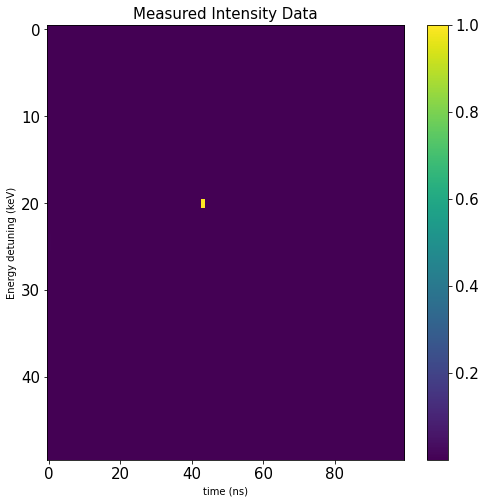

In [14]:
plt.figure(figsize=(8,8))
plt.title('Measured Intensity Data', fontsize=15)
plt.imshow(measured_data_list,interpolation='nearest',aspect='auto')
plt.xlabel('time (ns)', fontsize=10)
plt.ylabel('Energy detuning (keV)', fontsize=10)
plt.colorbar()
plt.show()

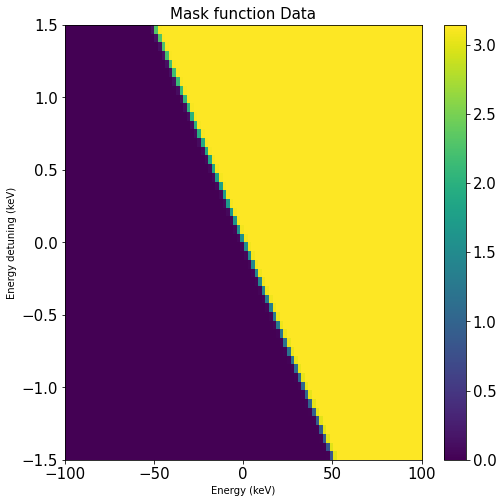

In [15]:
plt.figure(figsize=(8,8))
plt.xlabel('Energy (keV)', fontsize=10)
plt.ylabel('Energy detuning (keV)', fontsize=10)
plt.title('Mask function Data', fontsize=15)
plt.imshow(np.angle(mask_data_list),interpolation='nearest',aspect='auto', extent = [w[0] , w[-1], -1.5 , 1.5])
plt.colorbar()
plt.show()

<Figure size 576x576 with 0 Axes>

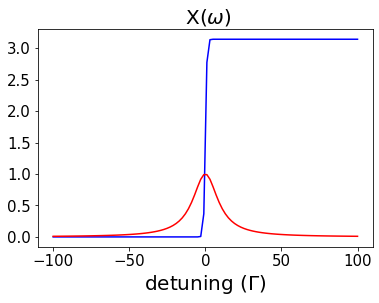

In [16]:
plt.figure(figsize=(8,8))
fig,ax= plt.subplots()
ax.plot(w, np.angle(sample_data), color = "blue")
ax.plot(w, np.abs(sample_data), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = " X($\omega$)")
plt.show()

In [17]:
time_data[45:]

array([199.65128755, 204.08798283, 208.52467811, 212.96137339,
       217.39806867, 221.83476395, 226.27145923, 230.70815451,
       235.14484979, 239.58154506, 244.01824034, 248.45493562,
       252.8916309 , 257.32832618, 261.76502146, 266.20171674,
       270.63841202, 275.0751073 , 279.51180258, 283.94849785,
       288.38519313, 292.82188841, 297.25858369, 301.69527897,
       306.13197425, 310.56866953, 315.00536481, 319.44206009,
       323.87875536, 328.31545064, 332.75214592, 337.1888412 ,
       341.62553648, 346.06223176, 350.49892704, 354.93562232,
       359.3723176 , 363.80901288, 368.24570815, 372.68240343,
       377.11909871, 381.55579399, 385.99248927, 390.42918455,
       394.86587983, 399.30257511, 403.73927039, 408.17596567,
       412.61266094, 417.04935622, 421.4860515 , 425.92274678,
       430.35944206, 434.79613734, 439.23283262])

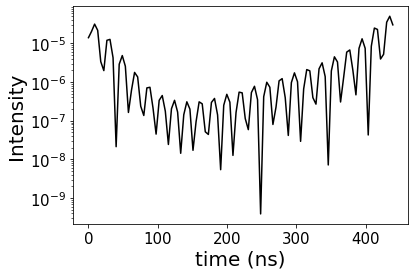

In [18]:
fig,ax= plt.subplots()

ax.semilogy(time_data,measured_data_list[2], color = "black")
#ax.plot(w, exp_phase)
#ax.set_xlim([0,800])
ax.set(xlabel = "time (ns)",
       ylabel = "Intensity")
#ax.xaxis.label.set_size(20)
#ax.yaxis.label.set_size(20)

plt.show()

## TESTING section!!!!!!


#### Preprocessing: Take an intelligent guess of the object initialisation

In [19]:
K =np.diag(np.sum(abs(mask_data_list)**2,axis=0))
K_inv = np.diag(1.0/np.sum(abs(mask_data_list)**2,axis=0))
sum_Qb =np.zeros_like(mask_data_list[0])
for i in range(len(mask_data_list)):
    sum_Qb += np.conj(mask_data_list[i])*(measured_data_list[i])
    
obj_0 = K_inv.dot(sum_Qb) #initialize object function  

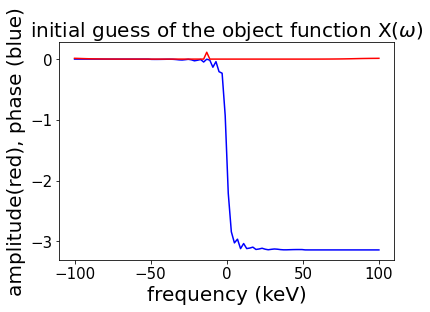

In [20]:
fig,ax= plt.subplots()
ax.plot(w, np.angle(obj_0), color = "blue")
ax.plot(w, np.abs(obj_0), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency (keV)",
       ylabel = "amplitude(red), phase (blue)",
       title = "initial guess of the object function X($\omega$)")
plt.show()

### PIE algorithm (Rodenberg)

In [21]:
def HannosMethod(mask_data_list, measured_data_list, obj_0, alpha, beta,max_iter):
    
    obj_n = obj_0
    z_c = np.zeros_like(obj_0)
    for n in range(0,max_iter):
        
        L= len(mask_data_list)
        
        
        for i in range(L): #iterates over all different probe positions i

            #for the i-th copy of the measured signal

            a = mask_data_list[i] #probe function
            a_star = np.conj(a) #probe* function
            psi_guess= a*obj_n #exit wave
            z= np.fft.ifft(psi_guess) # exit wave in time plane
            #z_c[:180]= z[:180]
            
            b = np.sqrt(measured_data_list[i]) #b_i = sqrt(I_i) real measured amplitude of the convoluted signal
            #b = b/LA.norm(b) #normalise b
            z_c =b*np.exp(1j*np.angle(z)) # z_c(t) corrected conv signal guess in t domain
            psi_corrected =  np.fft.fft(z_c) #corrected exit wave
            
            #object update
            #obj_n = obj_n+ beta* abs(a)/max(abs(a)) *  abs(a)/(abs(a)**2 + alpha)*(psi_corrected-psi_guess)
            obj_n = obj_n+ alpha* 1/( (abs(a))**2 +0.000000001) *(a_star)*(psi_corrected-psi_guess)
            #obj_n = obj_n+ alpha* 1/( max(abs(a))**2 +0.000000001) *(a_star)*(psi_corrected-psi_guess)
        
        
        
    #print('Exceeded maximum iterations. No solution found.')
            
    return obj_n

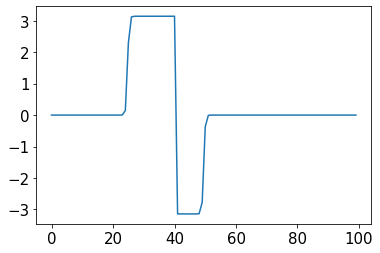

In [22]:
obj_0 = sample_data
a = mask_data_list[0] #probe function
a_star = np.conj(a) #probe function
psi_guess= a*obj_0
plt.plot(np.angle(psi_guess))

In [23]:
z= np.fft.ifft(psi_guess)
b = np.sqrt(measured_data_list[0]) #b_i = sqrt(I_i) real measured amplitude of the convoluted signal
b = normalise(b) #normalise b
z_c =b*np.exp(1j*np.angle(z)) # z_c(t) corrected conv signal guess in t domain
psi_corrected =  np.fft.fft(z_c)
plt.plot(np.angle(psi_corrected))

NameError: name 'normalise' is not defined

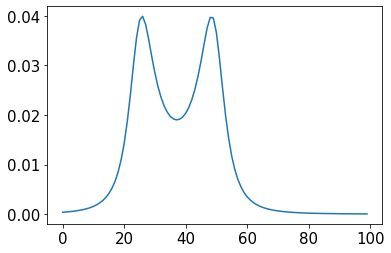

In [24]:
plt.plot(np.abs(psi_guess))

In [25]:
psi_guess= a*obj_0
threshold = max(abs(psi_guess))/100000; #tolerance threshold
psi_guess[abs(psi_guess)<threshold] = 0; #maskout values that are below the threshold
zz = np.fft.ifft(psi_guess)
threshold = max(abs(zz))/100000; #tolerance threshold
zz[abs(zz)<threshold] = 0; #maskout values that are below the threshold
z= np.fft.fft(zz);#store the FFT results in another array
#detect noise (very small numbers (eps)) and ignore them
#threshold = max(abs(z))/10000; #tolerance threshold
#z[abs(z)<threshold] = 0; #maskout values that are below the threshold


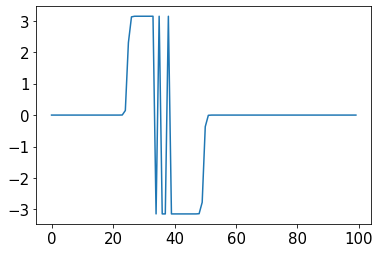

In [26]:
plt.plot(np.angle(z))

In [27]:
phase=atan2(imag(X2),real(X2))*180/pi; %phase information
plt.plot(phase); %phase vs frequencies

SyntaxError: invalid syntax (<ipython-input-27-49e689d90b2f>, line 1)

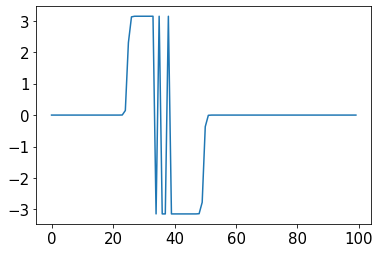

In [28]:
plt.plot(np.angle(np.fft.fft(np.fft.ifft(psi_guess))))

In [29]:
z= np.fft.ifft(psi_guess)

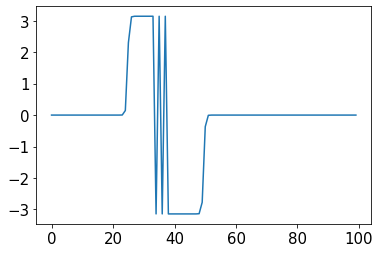

In [30]:
plt.plot(np.angle(np.fft.fft(np.abs(z)*np.exp(1j*np.angle(z)))))

In [31]:
z= np.fft.ifft(psi_guess)
b = np.sqrt(measured_data_list[0]) #b_i = sqrt(I_i) real measured amplitude of the convoluted signal
b = normalise(b) #normalise b
z_c =b*np.exp(1j*np.angle(z)) # z_c(t) corrected conv signal guess in t domain
psi_corrected =  np.fft.fft(z_c)
plt.plot(np.abs(psi_corrected))

NameError: name 'normalise' is not defined

In [32]:
a_star*a /(abs(a)**2+0.000000001)

array([0.99999932+0.j, 0.99999942+0.j, 0.99999951+0.j, 0.99999959+0.j,
       0.99999966+0.j, 0.99999971+0.j, 0.99999976+0.j, 0.99999981+0.j,
       0.99999984+0.j, 0.99999988+0.j, 0.9999999 +0.j, 0.99999992+0.j,
       0.99999994+0.j, 0.99999996+0.j, 0.99999997+0.j, 0.99999998+0.j,
       0.99999998+0.j, 0.99999999+0.j, 0.99999999+0.j, 0.99999999+0.j,
       1.        +0.j, 1.        +0.j, 1.        +0.j, 1.        +0.j,
       1.        +0.j, 1.        +0.j, 1.        +0.j, 1.        +0.j,
       1.        +0.j, 1.        +0.j, 1.        +0.j, 0.99999999+0.j,
       0.99999999+0.j, 0.99999999+0.j, 0.99999998+0.j, 0.99999997+0.j,
       0.99999996+0.j, 0.99999995+0.j, 0.99999993+0.j, 0.99999991+0.j,
       0.99999989+0.j, 0.99999986+0.j, 0.99999983+0.j, 0.99999979+0.j,
       0.99999974+0.j, 0.99999969+0.j, 0.99999962+0.j, 0.99999955+0.j,
       0.99999947+0.j, 0.99999937+0.j, 0.99999927+0.j, 0.99999915+0.j,
       0.99999902+0.j, 0.99999887+0.j, 0.99999871+0.j, 0.99999853+0.j,
      

In [33]:
obj_0 = np.random.random(len(mask_data_list[0]))*np.exp(1j*np.random.random(len(mask_data_list[0])))
#obj_0 = sample_data

In [34]:
#apply the Hanno method
#apply the Hanno method

# choice of beta??
alpha = 1
beta = 0.1
max_iter = 1000
approx_obj = HannosMethod(np.sqrt(mask_data_list), measured_data_list, obj_0, alpha, beta,max_iter)


#print(approx_obj) #give the x for which p(x)=0


In [35]:
def normalise(x): 
    return (x-min(x))/abs(max(x)-min(x))

<Figure size 1080x1080 with 0 Axes>

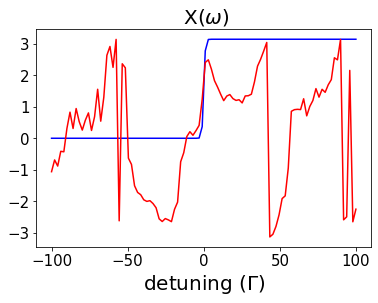

In [36]:
plt.figure(figsize=(15,15))
fig,ax= plt.subplots()
#ax.plot(w, normalise(np.abs(approx_obj)), color = "blue")
#ax.plot(w, normalise(np.abs(sample_data)), color = "red")
ax.plot(w, np.angle(sample_data), color = "blue")
ax.plot(w, np.angle(approx_obj), color = "red")
#ax.plot(w, np.angle(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = " X($\omega$)")
plt.show()

## STEEPEST DESCENT ALGORITHM

In [37]:
#function to implement Newton's method
def SteepestDescent2(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object)
        
        #Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0 #initial guess of the object
    
    
    rho = np.zeros(max_iter)
    
    for n in range(0,max_iter-1):
        
        #1. find error and further gradient of error in the object guess 

        ###########calculate rho, drho, ddrho(Hessian)####################
  
        rho_n, Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
        
        #2. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        
        rho[n] = rho_n
        
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n, rho, n
        
        #3. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho, n
        
        #apply an update to object guess (obj_n):     
        
        p_n= -Drho_n #search direction for steepest descent
        
        
        
        obj_n = obj_n+beta*p_n #standard optimization algorithm update
        rho_n_1 = rho_n
        
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho,n

In [75]:
#apply the steepest descent algorithm

# choice of 1>beta>0-- 0.05


beta,epsilon,max_iter=0.5,0.1,1000
approx_obj,rho,run_iter = SteepestDescent2(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter) 
#print(approx_obj) #give the x for which p(x)=0

Exceeded maximum iterations. No solution found.


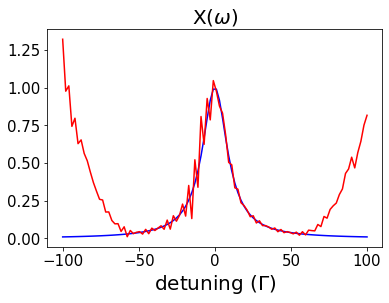

<Figure size 1800x1800 with 0 Axes>

In [76]:
fig,ax= plt.subplots()
plt.figure(figsize=(25,25))
ax.plot(w, np.abs(sample_data), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "detuning ($\Gamma$)",
       ylabel = "",
       title = "X($\omega$)")
plt.show()

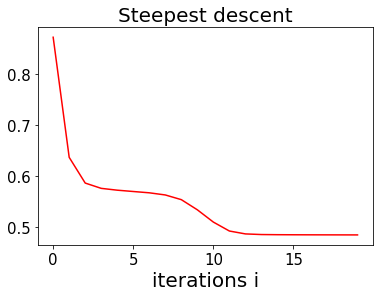

In [79]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho[0: 20], color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = "",
       title = "Steepest descent")
plt.show()

## Conjugate Gradient Method

In [513]:
#function to implement Newton's method
def ConjGradient(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object)
        
        #Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0 #initial guess of the object
    rho = np.zeros(max_iter)
    
    p_n_1 =  np.random.random(len(mask_data_list[0])) np.random.random(len(mask_data_list[0])) * 1j
    Drho_n_1 = np.random.random(len(mask_data_list[0])) + np.random.random(len(mask_data_list[0])) * 1j
    for n in range(0,max_iter):
        
        #1. find error and further gradient of error in the object guess 

        ###########calculate rho, drho, ddrho(Hessian)####################
        
        rho_n, Drho_n = get_rho(obj_n, mask_data_list, measured_data_list)
        rho[n] = rho_n
        #2. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n,rho,n
        
        #3. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho,n
        
        #apply an update to object guess (obj_n):
        
        
        alpha = np.conj(np.transpose(Drho_n)).dot(
                                            Drho_n -Drho_n_1 
                                           ).real / LA.norm(Drho_n_1)**2
        
        p_n= -Drho_n + alpha*p_n_1 #search direction for steepest descent
        
        obj_n = obj_n+beta*p_n #standard optimization algorithm update
        
        D_rho_n_1= Drho_n
        p_n_1 =p_n
        
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho,n

In [514]:


# choice of 1>beta>0-- 0.05


beta,epsilon,max_iter=0.05,0.00001,500
approx_obj,rho,run_iter = ConjGradient(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter) 
#print(approx_obj) #give the x for which p(x)=0

<ipython-input-513-fedaa39a468c>:66: RuntimeWarning: invalid value encountered in multiply
  obj_n = obj_n+beta*p_n #standard optimization algorithm update
<ipython-input-513-fedaa39a468c>:64: RuntimeWarning: invalid value encountered in multiply
  p_n= -Drho_n + alpha*p_n_1 #search direction for steepest descent


Exceeded maximum iterations. No solution found.


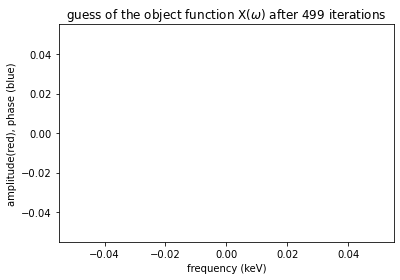

In [515]:
fig,ax= plt.subplots()
ax.plot(w, np.angle(approx_obj), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency (keV)",
       ylabel = "amplitude(red), phase (blue)",
       title = "guess of the object function X($\omega$) after " +str(run_iter)+" iterations")
plt.show()

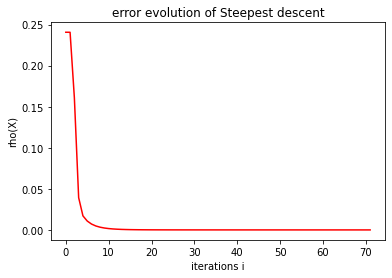

In [72]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho[0: run_iter], color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = "rho(X)",
       title = "error evolution of Steepest descent")
plt.show()

### Newton's Method

In [153]:
#function to implement Newton's method
def Newton(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object)
        
        #Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0 #initial guess of the object
    rho = np.zeros(max_iter)
    
    for n in range(0,max_iter):
        
        #1. find error and further gradient of error in the object guess 

        ###########calculate rho, drho, ddrho(Hessian)####################
        
        rho_n,Drho_n,Hessian_n = getErrorFunc(obj_n, mask_data_list, measured_data_list)
        rho[n] = rho_n
        #2. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n,rho,n
        
        #3. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho,n
        
        #apply an update to object guess (obj_n):
        
        
        
        p_n= -(LA.inv(Hessian_n)**2).dot( np.concatenate( (Drho_n, np.conj(Drho_n)),axis =0 ) ) #search direction for Newton's algorithm
        #print(type(p_n))
        p_n = np.squeeze(np.asarray(p_n))
        p_n_part = p_n[0: len(obj_n)-80]
        
        obj_n = obj_n+beta*p_n_part[0] #standard optimization algorithm update
        
        #obj_n = np.transpose(obj_n)
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho,n

In [157]:


# choice of 1>beta>0-- 0.05


beta,epsilon,max_iter=0.05,0.01,50
approx_obj,rho,run_iter = Newton(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter) 
#print(approx_obj) #give the x for which p(x)=0

<ipython-input-2-96dbbb3b87ca>:91: RuntimeWarning: overflow encountered in power
  np.diag(b*z**2/abs(z)**3 ).dot(
<ipython-input-2-96dbbb3b87ca>:46: RuntimeWarning: overflow encountered in double_scalars
  rho+=0.5*LA.norm(r)**2 # rho (for nth iteration) = 0.5*||r||^2
<ipython-input-2-96dbbb3b87ca>:91: RuntimeWarning: overflow encountered in square
  np.diag(b*z**2/abs(z)**3 ).dot(
<ipython-input-2-96dbbb3b87ca>:91: RuntimeWarning: invalid value encountered in square
  np.diag(b*z**2/abs(z)**3 ).dot(
<ipython-input-2-96dbbb3b87ca>:91: RuntimeWarning: invalid value encountered in multiply
  np.diag(b*z**2/abs(z)**3 ).dot(


Exceeded maximum iterations. No solution found.


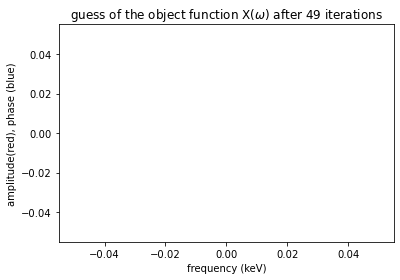

In [158]:
fig,ax= plt.subplots()
ax.plot(w, np.angle(approx_obj), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency (keV)",
       ylabel = "amplitude(red), phase (blue)",
       title = "guess of the object function X($\omega$) after " +str(run_iter)+" iterations")
plt.show()

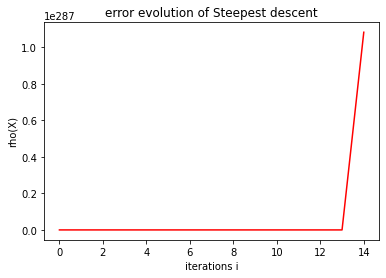

In [161]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho[0: run_iter], color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = "rho(X)",
       title = "error evolution of Steepest descent")
plt.show()

In [69]:
#apply the steepest descent algorithm

# choice of beta -- 0.5


eta,beta,alpha,epsilon,max_iter=1.0,0.5,0.5,0.00001,500
approx_obj,rho = SteepestDescent0(mask_data_list, measured_data_list, obj_0, eta, beta, alpha, epsilon, max_iter) 
#print(approx_obj) #give the x for which p(x)=0

KeyboardInterrupt: 

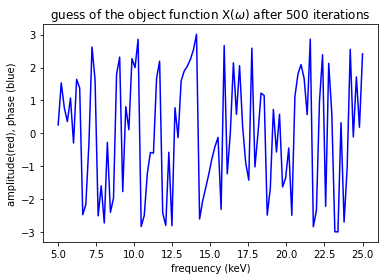

In [292]:
fig,ax= plt.subplots()
ax.plot(w, np.angle(approx_obj), color = "blue")
#ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency (keV)",
       ylabel = "amplitude(red), phase (blue)",
       title = "guess of the object function X($\omega$) after " +str(max_iter)+" iterations")
plt.show()

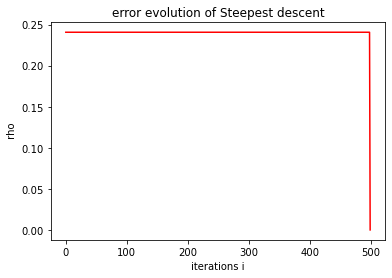

In [245]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho, color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = " rho",
       title = "error evolution of Steepest descent")
plt.show()

In [287]:
#apply the conjugate gradient algorithm

# choice of beta??

beta,epsilon,max_iter=0.5,0.00001,50
approx_obj,rho = SteepestDescent2(mask_data_list, measured_data_list, obj_0, beta, epsilon, max_iter) 
#print(approx_obj) #give the x for which p(x)=0

Exceeded maximum iterations. No solution found.


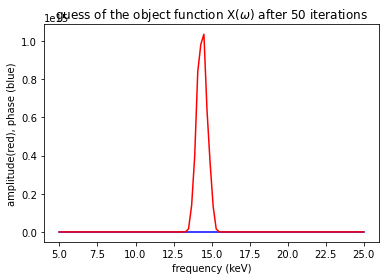

In [289]:
fig,ax= plt.subplots()
ax.plot(w, np.angle(approx_obj), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency (keV)",
       ylabel = "amplitude(red), phase (blue)",
       title = "guess of the object function X($\omega$) after " +str(max_iter)+" iterations")
plt.show()

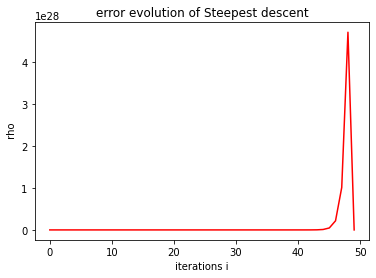

In [212]:
fig,ax= plt.subplots()
#ax.plot(w, np.angle(Drho_n),color ="blue")
ax.plot( rho, color ="red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "iterations i",
       ylabel = " rho",
       title = "error evolution of Steepest descent")
plt.show()

In [ ]:
#apply the Hanno method

# choice of beta??
approx_obj = HannosMethod(mask_data_list, measured_data_list, obj_0, 0.1, 0.00001,1000) 
#print(approx_obj) #give the x for which p(x)=0


In [ ]:
fig,ax= plt.subplots()
ax.plot(w, np.angle(approx_obj), color = "blue")
ax.plot(w, np.abs(approx_obj), color = "red")
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency (keV)",
       ylabel = "amplitude(red), phase (blue)",
       title = "guess of the object function X($\omega$) after " +str(max_iter)+" iterations")
plt.show()

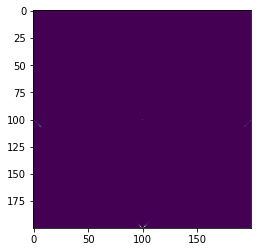

In [421]:
plt.imshow(np.abs(LA.inv(Hessian_n)))

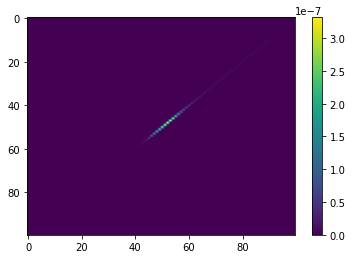

In [234]:
plt.imshow(abs(H_22),aspect='auto')
plt.colorbar()
plt.show()

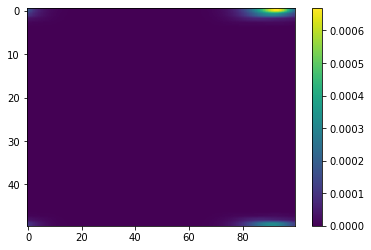

In [39]:
measured_data_list=np.fft.fft(measured_data_list, axis =0)

plt.imshow(abs(measured_data_list),aspect='auto')
plt.colorbar()
plt.show()

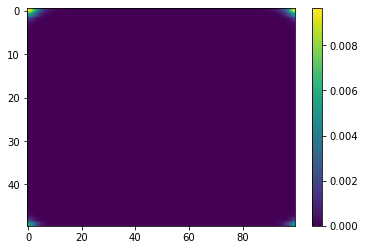

In [40]:
measured_data_list=np.fft.fft(measured_data_list, axis =1)

plt.imshow(abs(measured_data_list),aspect='auto')
plt.colorbar()
plt.show()

<ipython-input-323-7520c062c6ff>:42: RuntimeWarning: overflow encountered in absolute
  rho_n+=0.5*LA.norm(abs(z)-measured_data_list[i])**2
<ipython-input-323-7520c062c6ff>:54: RuntimeWarning: overflow encountered in absolute
  Drho_n+= 0.5*( Q_star.dot(Q.dot(obj_n)) - Q_star.dot(np.fft.fft(np.diag(z/abs(z))).dot(measured_data_list[i]))  )


Exceeded maximum iterations. No solution found.
None


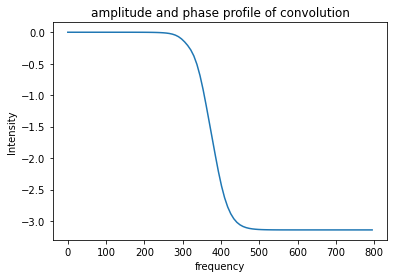

In [356]:

fig,ax= plt.subplots()
ax.plot(w, np.angle(obj_0))
#ax.plot(w, exp_phase)
ax.set(xlabel = "frequency",
       ylabel = "Intensity",
       title = "amplitude and phase profile of convolution")
plt.show()

### Wigner Deconvolution

In [32]:
#function to implement Newton's method
def newton(mask_data_list, measured_data_list, obj_0,epsilon,max_iter):

    obj_n = obj_0
    
    while jjkkkk
    img_guess = np.abs(np.fft.ifft(mask_data_list.dot(obj_0)))**2
    measured_data_list - img_guess = epsilon
    
    obj_n = obj_n + 
    
    
    
    
    
    for n in range(0,max_iter):
        rho_n = 0
        for i in range(len(mask_data_list)):
            Q = np.diag(mask_data_list[i])
            z= np.fft.ifft(Q.dot(obj_n))
            rho_n+=0.5*LA.norm(abs(z)-measured_data_list[i])**2
            
        if abs(rho_n) < epsilon:
            print('Found solution after',n,'iterations.')
            return obj_n
        
        Drho_n = np.zeros_like(mask_data_list[0]) 
        
        for i in range(len(mask_data_list)):
            Q = np.diag(mask_data_list[i])
            Q_star = np.diag(np.conj(mask_data_list[i]))
            z= np.fft.ifft(Q.dot(obj_n))
            Drho_n+= 0.5*( Q_star.dot(Q.dot(obj_n)) - Q_star.dot(np.fft.fft(np.diag(z/abs(z))).dot(measured_data_list[i]))  )
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return None
        
        obj_n = obj_n-2*Drho_n
    print('Exceeded maximum iterations. No solution found.')
            
    return None

SyntaxError: invalid syntax (<ipython-input-32-cc443aa235f6>, line 6)

## ROUGH WORK

In [261]:
test[abs(test) <1e-19] =10

In [262]:
test

array([[1.+1.j, 1.+0.j],
       [1.+0.j, 2.+2.j]])

In [409]:
test1 =np.array([1,2])
test2 =np.array([3,4])
test3 = np.append(test1,test2)

In [410]:
print(test3)

[1 2 3 4]


In [411]:
type(test3)

numpy.ndarray

In [595]:
test1*test2

array([3, 8])

In [761]:
#function to implement Newton's method
def HannosMethod0(mask_data_list, measured_data_list, obj_0, alpha, beta, epsilon, max_iter):
    
    
    '''Approximate solution of rho(obj)=0 by ITERATIVE SD method.

    Parameters
    ----------
    rho : error function
        Function for which we are searching for a solution rho(obj)=0.
    Drho : function
        Derivative of rho(obj).
    obj_0 : vector (Signal object)
        Initial guess for a solution rho(obj)=0. 
    epsilon : number
        Stopping criteria is abs(rho(obj)) < epsilon.
    max_iter : integer
        Maximum number of iterations of iterative method.

    Returns
    -------
    obj_n : vector (Signal object)
        
        #Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.
    '''
 
    obj_n = obj_0 #initial guess of the object
    
    
    rho = np.zeros(max_iter)
    
    for n in range(0,max_iter-1):
        
        #1. find error and further gradient of error in the object guess 

        ###########calculate rho, drho, ddrho(Hessian)####################
  
        rho_n, Drho_n = get_rho_regularised(obj_n, mask_data_list, measured_data_list,alpha)
        
        #2. Check if the object guess error is acceptable. We want to have error rho_n as close to 0 as possible.
        #If it is, exit the program!
        
        rho[n] = rho_n
        
        if abs(rho_n) < epsilon:  
            print('Found solution after',n,'iterations.')
            return obj_n, rho, n
        
        #3. Check if the object guess is stuck at an inflexion point.
            
        if np.all(Drho_n==0):
            print('Gradient is zero. No solution found.')
            return obj_n, rho, n
        
        #apply an update to object guess (obj_n):     
        
        p_n= -Drho_n #search direction for steepest descent
        
        
        obj_n = obj_n+beta*p_n #standard optimization algorithm update
        
    print('Exceeded maximum iterations. No solution found.')
            
    return obj_n, rho, n